# <center> Bayesian Risk Assesment Using Cybersecurity Data

+-------------------+----------------------+
| Vulnerability     |   phi(Vulnerability) |
+===================+======================+
| Vulnerability(V1) |               0.3333 |
+-------------------+----------------------+
| Vulnerability(V2) |               0.6667 |
+-------------------+----------------------+
| Vulnerability(V3) |               0.0000 |
+-------------------+----------------------+
| Vulnerability(V4) |               0.0000 |
+-------------------+----------------------+
| Vulnerability(V5) |               0.0000 |
+-------------------+----------------------+
| Vulnerability(V6) |               0.0000 |
+-------------------+----------------------+
+--------------------+----------------------+
| Attack_Vector      |   phi(Attack_Vector) |
+====================+======================+
| Attack_Vector(AV1) |               0.0000 |
+--------------------+----------------------+
| Attack_Vector(AV2) |               0.5000 |
+--------------------+----------------------+
| A

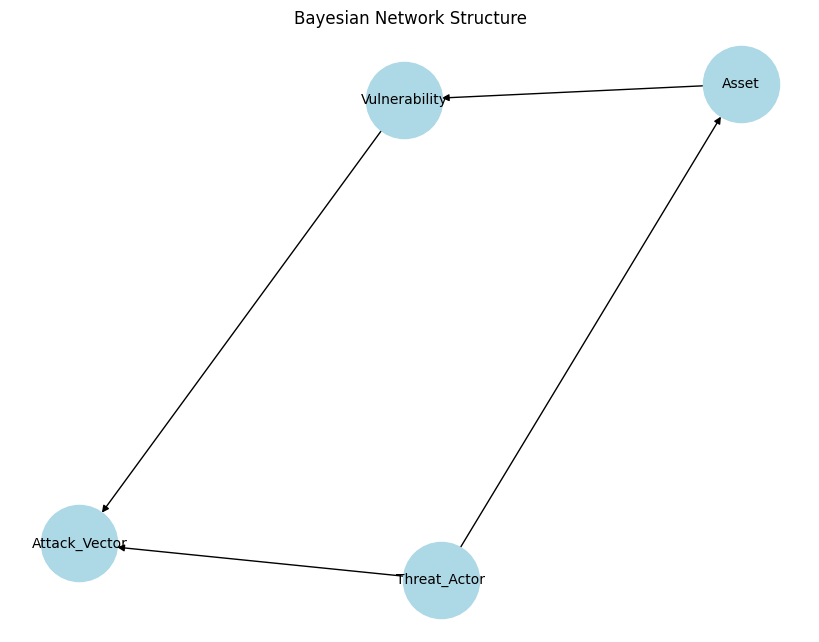

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Sample Data for 4 datasets with additional attributes
asset_vuln_data = pd.DataFrame({
    'Asset': ['A1', 'A1', 'A2', 'A3', 'A3', 'A4', 'A4', 'A5', 'A5', 'A6'],
    'Vulnerability': ['V1', 'V2', 'V2', 'V3', 'V4', 'V4', 'V5', 'V5', 'V6', 'V6'],
    'CVSS_Score': [7.5, 5.3, 6.2, 8.0, 4.1, 5.6, 7.8, 6.9, 5.0, 4.8],
    'Exploit_Probability': [0.9, 0.7, 0.8, 0.95, 0.5, 0.6, 0.85, 0.75, 0.65, 0.6]
})

vuln_attack_data = pd.DataFrame({
    'Vulnerability': ['V1', 'V2', 'V2', 'V3', 'V4', 'V4', 'V5', 'V5', 'V6', 'V6'],
    'Attack_Vector': ['AV1', 'AV2', 'AV3', 'AV3', 'AV4', 'AV5', 'AV5', 'AV6', 'AV6', 'AV7'],
    'Success_Probability': [0.85, 0.65, 0.75, 0.9, 0.4, 0.55, 0.8, 0.7, 0.6, 0.5]
})

threat_asset_data = pd.DataFrame({
    'Threat_Actor': ['TA1', 'TA1', 'TA2', 'TA2', 'TA3', 'TA3', 'TA4', 'TA4', 'TA5', 'TA6'],
    'Asset': ['A1', 'A2', 'A2', 'A3', 'A3', 'A4', 'A4', 'A5', 'A5', 'A6'],
    'Target_Probability': [0.9, 0.8, 0.85, 0.75, 0.6, 0.7, 0.95, 0.8, 0.7, 0.65]
})

threat_attack_data = pd.DataFrame({
    'Threat_Actor': ['TA1', 'TA2', 'TA2', 'TA3', 'TA4', 'TA4', 'TA5', 'TA5', 'TA6', 'TA6'],
    'Attack_Vector': ['AV1', 'AV2', 'AV3', 'AV3', 'AV4', 'AV5', 'AV5', 'AV6', 'AV6', 'AV7'],
    'Success_Rate': [0.88, 0.72, 0.78, 0.9, 0.45, 0.6, 0.83, 0.73, 0.67, 0.55]
})

# Discretizing numerical attributes into bins
def discretize(column, bins, labels):
    return pd.cut(column, bins=bins, labels=labels)

bins = [0, 4, 6, 8, 10]  # CVSS Score Bins
labels = ['Low', 'Medium', 'High', 'Critical']
asset_vuln_data['CVSS_Score'] = discretize(asset_vuln_data['CVSS_Score'], bins, labels)

bins = [0, 0.5, 0.75, 1.0]  # Probability Bins
labels = ['Low', 'Medium', 'High']
asset_vuln_data['Exploit_Probability'] = discretize(asset_vuln_data['Exploit_Probability'], bins, labels)
vuln_attack_data['Success_Probability'] = discretize(vuln_attack_data['Success_Probability'], bins, labels)
threat_asset_data['Target_Probability'] = discretize(threat_asset_data['Target_Probability'], bins, labels)
threat_attack_data['Success_Rate'] = discretize(threat_attack_data['Success_Rate'], bins, labels)

# Ensure categorical columns have 'Unknown' as a category
for df in [asset_vuln_data, vuln_attack_data, threat_asset_data, threat_attack_data]:
    for col in df.select_dtypes(include=['category']).columns:
        df[col] = df[col].cat.add_categories('Unknown')

# Combine datasets for Bayesian Network Training
data = asset_vuln_data.merge(vuln_attack_data, on='Vulnerability')
data = data.merge(threat_asset_data, on='Asset', how='left')
data = data.merge(threat_attack_data, on=['Threat_Actor', 'Attack_Vector'], how='left').fillna('Unknown')

# Define Bayesian Network Structure
model = BayesianNetwork([('Asset', 'Vulnerability'), ('Vulnerability', 'Attack_Vector'), 
                         ('Threat_Actor', 'Asset'), ('Threat_Actor', 'Attack_Vector')])

# Estimate CPTs using Maximum Likelihood Estimation
model.fit(data, estimator=MaximumLikelihoodEstimator)

# Perform inference
inference = VariableElimination(model)
prob_v_given_a = inference.query(variables=['Vulnerability'], evidence={'Asset': 'A1'})
prob_av_given_v = inference.query(variables=['Attack_Vector'], evidence={'Vulnerability': 'V2'})
prob_a_given_ta = inference.query(variables=['Asset'], evidence={'Threat_Actor': 'TA2'})
prob_av_given_ta = inference.query(variables=['Attack_Vector'], evidence={'Threat_Actor': 'TA3'})

# Print results
print(prob_v_given_a)
print(prob_av_given_v)
print(prob_a_given_ta)
print(prob_av_given_ta)

# Plot the Bayesian Network
graph = nx.DiGraph()
for edge in model.edges():
    graph.add_edge(edge[0], edge[1])

plt.figure(figsize=(8, 6))
nx.draw(graph, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10)
plt.title("Bayesian Network Structure")
plt.show()